In [9]:
import click
import evaluate
import numpy as np
from datasets import Dataset
import datasets as ds
from transformers import (
    DataCollatorForSeq2Seq,
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator,
)


In [10]:
import pandas as pd
import functools as ft

In [11]:
model_name = "google/mt5-small"
flores_path = "./data-bin/flores-dev-no-orth"
ntrex_path = "./data-bin/ntrex-no-orth"
source_lang = "fin"
target_lang = "eng"
finetune_langs = "fin,eng,est".split(",")

In [12]:
# Load the MT5 tokenizer and model
tokenizer = MT5Tokenizer.from_pretrained(model_name)

flores = ds.load_from_disk(flores_path)
ntrex = ds.load_from_disk(ntrex_path)

# Define new dataset based on source and target lang as well as finetuning langs
source_data_finetune = ds.concatenate_datasets(
    [ntrex[lang] for lang in ntrex if ntrex[lang].num_rows == ntrex[target_lang].num_rows]
)  # .rename_column("text", "source")
target_data_finetune = ds.concatenate_datasets(
    [ntrex[target_lang] for lang in ntrex if ntrex[lang].num_rows == ntrex[target_lang].num_rows]
)  # .rename_column("text", "target")

data_for_finetune = ds.Dataset.from_dict(
    {
        "source": source_data_finetune["text"],
        "target": target_data_finetune["text"],
        "source_language": source_data_finetune["language"],
        "target_language": target_data_finetune["language"],
    }
)

# Define test data
source_data_test = flores[source_lang]
target_data_test = flores[target_lang]

data_for_test = ds.Dataset.from_dict(
    {
        "source": source_data_test["text"],
        "target": target_data_test["text"],
        "source_language": source_data_test["language"],
        "target_language": target_data_test["language"],
    }
)

In [13]:
ntrex_lengths = pd.Series({l: ntrex[l].num_rows for l in ntrex})

In [14]:
def preprocess_function(examples, max_length_tokens=128, add_prefix=True):

    if add_prefix:
        prefixes = [
            f"Translate from {srclang} to {tgtlang}: "

            for srclang, tgtlang in zip(
                examples["source_language"], examples["target_language"]
            )
        ]

        inputs = [f"{pf}{ex}" for pf, ex in zip(prefixes, examples["source"])]
    else:
        inputs = examples["source"]
    targets = examples["target"]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length_tokens, truncation=True
    )
    model_inputs["input_tokens"] = [
        tokenizer.convert_ids_to_tokens(ids) for ids in model_inputs["input_ids"]
    ]
    model_inputs["output_tokens"] = [
        tokenizer.convert_ids_to_tokens(ids) for ids in model_inputs["labels"]
    ]

    return model_inputs

## NTREX language names


In [15]:
import pandas as pd

In [16]:
%%bash
sed "s/\s/\t/" < data/ntrex/LANGUAGES.tsv > data/ntrex/LANGUAGES_tab.tsv

In [17]:
ntrex_languages = pd.read_csv("data/ntrex/LANGUAGES_tab.tsv", sep="\t", header=None, names=['language_code', 'language'])

In [18]:
ntrex_lang_code_to_language = ntrex_languages.set_index("language_code").language.to_dict()

In [19]:
def get_long_language_ntrex(lang_code: str) -> str:
    out = ntrex_languages[ntrex_languages.language_code.str.startswith(lang_code)].language.head(1).tolist().pop(0)
    return out.strip()

### Language overlap between NTREX and FLORES

Let's assume we're training on NTREX-128 and evaluating on FLORES. We can compute the language coverage and token overlap statistics:

In [20]:
in_flores = set(ntrex) & set(flores)
not_in_flores = set(ntrex) - set(flores)

In [21]:
language_coverage = len(in_flores) / len(set(ntrex))

print(f"Language coverage: {round(100*language_coverage, 2)}%")
print("Languages not covered by FLORES:\n{}".format('\n'.join(f"- {lang}: {get_long_language_ntrex(lang)}" for lang in not_in_flores)))

Language coverage: 81.67%
Languages not covered by FLORES:
- mey: Hassaniyya
- mon: Mongolian
- fuc: Pulaar
- msa: Malay
- pus: Pushto
- uzb: Uzbek
- shi: Shilha
- fil: Filipino
- aze: Azerbaijani (Latin)
- ton: Tonga (Tonga Islands)
- lav: Latvian
- hmn: Hmong
- orm: Oromo
- tah: Tahitian
- div: Divehi
- sqi: Albanian
- nep: Nepali
- fas: Persian
- swa: Swahili
- mlg: Malagasy
- nde: North Ndebele
- ven: Venda


In [22]:
print("Languages covered by FLORES:\n{}".format('\n'.join(f"- {lang}: {get_long_language_ntrex(lang)}" for lang in in_flores)))

Languages covered by FLORES:
- mlt: Maltese
- ron: Romanian
- tel: Telugu
- dzo: Dzongkha
- snd: Sindhi (Arabic)
- hye: Armenian
- jpn: Japanese
- slk: Slovak
- tam: Tamil
- prs: Dari
- hin: Hindi
- gle: Irish
- xho: Xhosa
- kan: Kannada
- kin: Kinyarwanda
- pol: Polish
- som: Somali
- tuk: Turkmen
- tha: Thai
- spa: Spanish
- ell: Greek
- pan: Panjabi
- tsn: Tswana
- zho: Chinese (Simplified)
- tat: Tatar
- est: Estonian
- sna: Shona (Latin)
- glg: Galician
- mar: Marathi
- por: Portuguese
- arb: Arabic
- kmr: Northern Kurdish (Kurmanji)
- mri: Maori
- bel: Belarusian
- dan: Danish
- nob: Norwegian Bokmål
- mkd: Macedonian
- kor: Korean
- bem: Bemba
- srp: Serbian (Cyrillic)
- amh: Amharic
- kir: Kyrgyz
- uig: Uighur
- hun: Hungarian
- yue: Cantonese
- ssw: Swati
- kaz: Kazakh
- nno: Norwegian Nynorsk
- afr: Afrikaans
- ind: Indonesian
- bul: Bulgarian
- khm: Khmer
- hrv: Croatian
- smo: Samoan
- nld: Dutch
- ita: Italian
- kat: Georgian
- bos: Bosnian
- slv: Slovenian
- bod: Tibetan


### Token overlap

First let's tokenize using the mT5 tokenizer:

In [23]:
import functools as ft

In [24]:
preprocess_no_prefix = ft.partial(preprocess_function, add_prefix=False)

In [25]:
data_for_finetune = data_for_finetune.map(preprocess_no_prefix, batched=True)

Map:   0%|          | 0/227658 [00:00<?, ? examples/s]

In [26]:
data_for_test = data_for_test.map(preprocess_no_prefix, batched=True)

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Now, we can compute overlap stats for subwords:

In [94]:
import itertools as it
from collections import Counter

def flatten(nested: list[list[str]], return_type=list) -> list[str]:
    return return_type(it.chain.from_iterable(nested))

def get_unique_tokens(examples):
    return flatten(examples, return_type=set)

def get_unique_token_counts(examples):
    return Counter(flatten(examples))

def bigrams(lst):
    return zip(lst, lst[1:])

def get_unique_bigram_counts(examples):
    bg = flatten(examples, return_type=lambda x: bigrams(list(x)))
    return Counter(bg)

Let's check how many redundant rows there are (should be 1997, the NTREX per-lang size):

In [28]:
# These rows are redundant since the source and target langs are the same
redundant_rows = data_for_finetune.filter(lambda d: d['source_language'] == d['target_language'])

Filter:   0%|          | 0/227658 [00:00<?, ? examples/s]

In [29]:
redundant_rows

Dataset({
    features: ['source', 'target', 'source_language', 'target_language', 'input_ids', 'attention_mask', 'labels', 'input_tokens', 'output_tokens'],
    num_rows: 1997
})

Yup that matches! So this means that even the English rows are in the source tokens. 

Now let's do the subword overlap:

In [30]:
subword_tokens_in_ntrex = get_unique_token_counts(data_for_finetune['input_tokens'])
subword_tokens_in_flores = get_unique_token_counts(data_for_test['input_tokens'])

In [31]:
df_subword_tokens_in_ntrex = pd.DataFrame.from_dict(subword_tokens_in_ntrex, orient='index', columns=['n_occ_ntrex'])
df_subword_tokens_in_ntrex.index.name = "subword"
df_subword_tokens_in_ntrex.reset_index(inplace=True)

In [32]:
df_subword_tokens_in_flores = pd.DataFrame.from_dict(subword_tokens_in_flores, orient='index', columns=['n_occ_flores'])
df_subword_tokens_in_flores.index.name = "subword"
df_subword_tokens_in_flores.reset_index(inplace=True)

In [61]:
subword_occurrence_combined = pd.merge(left=df_subword_tokens_in_flores, right=df_subword_tokens_in_ntrex, left_on='subword', right_on='subword')
subword_occurrence_combined = subword_occurrence_combined.sort_values("n_occ_ntrex", ascending=False).reset_index(drop=True)

In [62]:
subword_occurrence_combined.set_index("subword", inplace=True)
subword_occurrence_combined = subword_occurrence_combined.rename(columns={
    "n_occ_ntrex": "Occurrences (NTREX)",
    "n_occ_flores": "Occurrences (FLORES)"
})

In [80]:
BACKEND = "matplotlib"
pd.set_option("plotting.backend", BACKEND)

In [84]:
import matplotlib.pyplot as plt

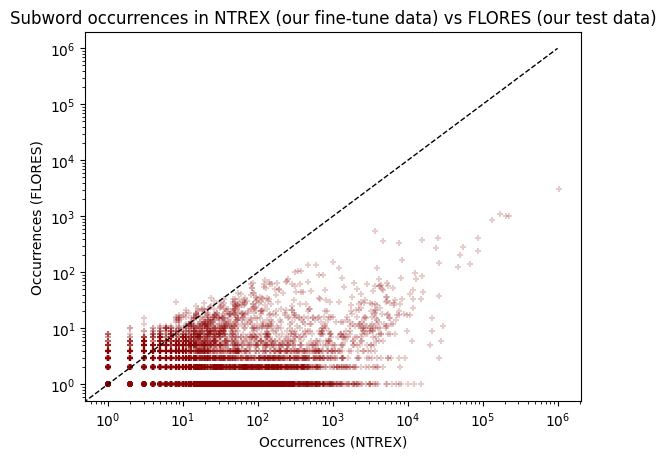

In [89]:
subword_occurrence_combined.plot(
    x='Occurrences (NTREX)', y='Occurrences (FLORES)', 
    logx=True, logy=True, kind='scatter', 
    title="Subword occurrences in NTREX (our fine-tune data) vs FLORES (our test data)",
    alpha=0.2, color='darkred', marker='+'
)
plt.plot([0, 10**6], [0, 10**6], linestyle='--', color='black', alpha=1, linewidth=1)

In [164]:
df = subword_occurrence_combined
df.assign(Difference=df['Occurrences (FLORES)'] - df['Occurrences (NTREX)']).sort_values("Difference", ascending=False)

,Occurrences (FLORES),Occurrences (NTREX),Difference
subword,,,
usein,30,8,22
▁kulttuuri,15,3,12
▁maailman,35,24,11
laiset,25,15,10
tuvat,21,11,10
...,...,...,...
a,850,134512,-133662
.,1099,170834,-169735
",",1017,202047,-201030


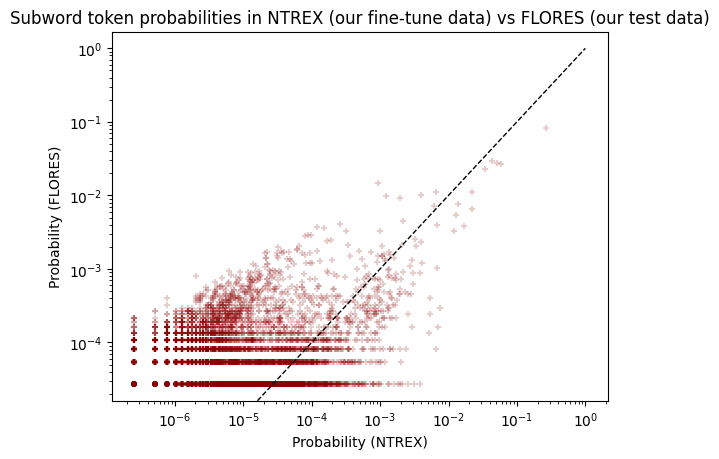

In [162]:
NORMALIZE=True

if NORMALIZE:
    df = subword_occurrence_combined / subword_occurrence_combined.sum(axis=0)
    df.rename(columns={"Occurrences (NTREX)": "Probability (NTREX)", 
                       "Occurrences (FLORES)": "Probability (FLORES)"}, inplace=True)
else:
    df = subword_occurrence_combined

df.plot(
    x='{} (NTREX)'.format("Probability" if NORMALIZE else "Occurrences"), 
    y='{} (FLORES)'.format("Probability" if NORMALIZE else "Occurrences"), 
    kind='scatter', 
    logx=True, logy=True, 
    title="Subword token {} in NTREX (our fine-tune data) vs FLORES (our test data)".format(
        "probabilities" if NORMALIZE else "occurrences"),
    alpha=0.2, color='darkred', marker='+'
)

x_top = 1 if NORMALIZE else df.max().max()
plt.plot([0, x_top], [0, x_top], linestyle='--', color='black', alpha=1, linewidth=1)

In [163]:
df.assign(Difference=df['Probability (FLORES)'] - df['Probability (NTREX)']).sort_values("Difference", ascending=False)

,Probability (FLORES),Probability (NTREX),Difference
subword,,,
▁ja,0.014622,0.000928,0.013695
▁on,0.009667,0.001200,0.008467
in,0.009129,0.001972,0.007157
en,0.010152,0.003952,0.006200
n,0.011175,0.006550,0.004626
...,...,...,...
.,0.029595,0.043759,-0.014165
e,0.006463,0.022055,-0.015592
",",0.027387,0.051755,-0.024368


Let's do the same for subword bigrams:

In [154]:
subword_bigrams_in_ntrex = get_unique_bigram_counts(data_for_finetune['input_tokens'])
subword_bigrams_in_flores = get_unique_bigram_counts(data_for_test['input_tokens'])

In [155]:
df_subword_bigrams_in_ntrex = pd.DataFrame.from_dict(subword_bigrams_in_ntrex, orient='index', columns=['n_occ_ntrex'])
df_subword_bigrams_in_ntrex.index.name = "subword"
df_subword_bigrams_in_ntrex.reset_index(inplace=True)

In [156]:
df_subword_bigrams_in_flores = pd.DataFrame.from_dict(subword_bigrams_in_flores, orient='index', columns=['n_occ_flores'])
df_subword_bigrams_in_flores.index.name = "subword"
df_subword_bigrams_in_flores.reset_index(inplace=True)

In [157]:
subword_bigram_occurrence_combined = pd.merge(left=df_subword_bigrams_in_flores, right=df_subword_bigrams_in_ntrex, left_on='subword', right_on='subword')
subword_bigram_occurrence_combined = subword_bigram_occurrence_combined.sort_values("n_occ_ntrex", ascending=False).reset_index(drop=True)

In [158]:
subword_bigram_occurrence_combined.set_index("subword", inplace=True)
subword_bigram_occurrence_combined = subword_bigram_occurrence_combined.rename(columns={
    "n_occ_ntrex": "Occurrences (NTREX)",
    "n_occ_flores": "Occurrences (FLORES)"
})

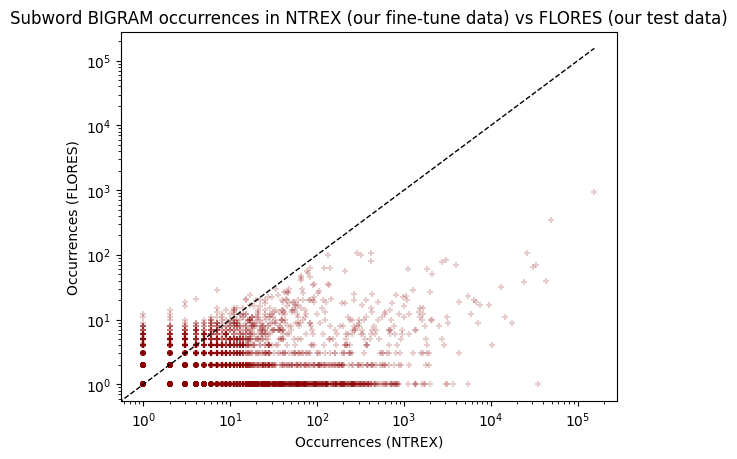

In [173]:
NORMALIZE=False

if NORMALIZE:
    df = subword_bigram_occurrence_combined / subword_bigram_occurrence_combined.sum(axis=0)
    df.rename(columns={"Occurrences (NTREX)": "Probability (NTREX)", 
                       "Occurrences (FLORES)": "Probability (FLORES)"}, inplace=True)
else:
    df = subword_bigram_occurrence_combined

df.plot(
    x='{} (NTREX)'.format("Probability" if NORMALIZE else "Occurrences"), 
    y='{} (FLORES)'.format("Probability" if NORMALIZE else "Occurrences"), 
    kind='scatter', 
    logx=True, logy=True, 
    title="Subword BIGRAM {} in NTREX (our fine-tune data) vs FLORES (our test data)".format(
        "probabilities" if NORMALIZE else "occurrences"),
    alpha=0.2, color='darkred', marker='+'
)

x_top = 1 if NORMALIZE else df.max().max()
plt.plot([0, x_top], [0, x_top], linestyle='--', color='black', alpha=1, linewidth=1)

In [175]:
df.assign(Difference=df['Occurrences (FLORES)'] - df['Occurrences (NTREX)']).sort_values("Difference", ascending=True)

,Occurrences (FLORES),Occurrences (NTREX),Difference
subword,,,
"(., </s>)",927,155542,-154615
"(,, ▁)",348,48925,-48577
"(▁, a)",40,42669,-42629
"(▁, i)",1,34605,-34604
"(</s>, ▁)",71,33108,-33037
...,...,...,...
"(▁saat, tavat)",14,2,12
"(▁käyttä, ä)",16,3,13
"(yle, ensä)",19,3,16


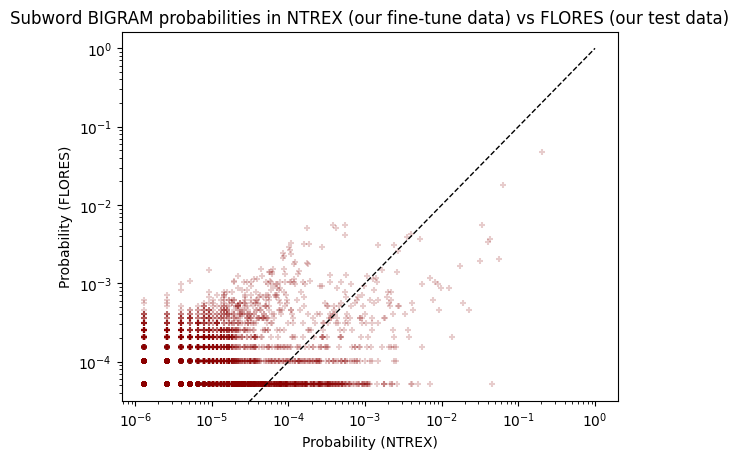

In [169]:
NORMALIZE=True

if NORMALIZE:
    df = subword_bigram_occurrence_combined / subword_bigram_occurrence_combined.sum(axis=0)
    df.rename(columns={"Occurrences (NTREX)": "Probability (NTREX)", 
                       "Occurrences (FLORES)": "Probability (FLORES)"}, inplace=True)
else:
    df = subword_bigram_occurrence_combined

df.plot(
    x='{} (NTREX)'.format("Probability" if NORMALIZE else "Occurrences"), 
    y='{} (FLORES)'.format("Probability" if NORMALIZE else "Occurrences"), 
    kind='scatter', 
    logx=True, logy=True, 
    title="Subword BIGRAM {} in NTREX (our fine-tune data) vs FLORES (our test data)".format(
        "probabilities" if NORMALIZE else "occurrences"),
    alpha=0.2, color='darkred', marker='+'
)

x_top = 1 if NORMALIZE else df.max().max()
plt.plot([0, x_top], [0, x_top], linestyle='--', color='black', alpha=1, linewidth=1)

Doesn't seem like there's any kind of discrepancies

In [170]:
df.assign(Difference=df['Probability (FLORES)'] - df['Probability (NTREX)']).sort_values("Difference", ascending=False)

,Probability (FLORES),Probability (NTREX),Difference
subword,,,
"(,, ▁ja)",0.005480,0.000376,0.005104
"(▁ja, ▁)",0.005480,0.000542,0.004938
"(▁, ovat)",0.005019,0.000172,0.004847
"(▁, että)",0.005122,0.000418,0.004704
"(▁on, ▁)",0.004149,0.000551,0.003598
...,...,...,...
"(</s>, ▁)",0.003637,0.043245,-0.039609
"(▁, i)",0.000051,0.045201,-0.045150
"(,, ▁)",0.017824,0.063905,-0.046081
